In [1]:
%pip install Sastrawi

Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [34]:
# Load dataset
df = pd.read_csv('smart_locker_reviews.csv', sep=";")

In [35]:
# df1.to_csv('s(2).csv', index=False)
df

,review,sentiment
0,"Kualitas smart locker ini sangat buruk, sering...",Negative
1,Desain smart locker sangat modern dan menarik.,Positive
2,Smart locker ini memiliki fitur yang cukup sta...,Neutral
3,"Keamanan smart locker ini sangat tinggi, saya ...",Positive
4,Smart locker ini sering tidak bisa diakses saa...,Negative
...,...,...
193,Tidak akurat.,Negative
194,Mudah digunakan.,Positive
195,Sering masalah.,Negative
196,Nyaman.,Positive


### Case Folding

In [36]:
# Ensure reviews are strings and lowercase
df['review'] = df['review'].astype(str).str.lower()

In [37]:
def clean_text(text):
    # Remove punctuation and special characters
    text = re.sub(r'[^\w\s]', '', text)
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    return text

df['cleaned_review'] = df['review'].apply(clean_text)

### Tokenizing

In [38]:
df['tokens'] = df['cleaned_review'].apply(word_tokenize)

### Stopword Removal

In [39]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\LimDaenery93\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [40]:
stop_words = set(stopwords.words('indonesian'))

def remove_stopwords(text):
    return [word for word in text if word not in stop_words]

df['tokens'] = df['tokens'].apply(remove_stopwords)

### Stemming

In [41]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def stem_tokenizer(text):
    return [stemmer.stem(word) for word in text]

df['tokens'] = df['tokens'].apply(stem_tokenizer)

df['processed_review'] = df['tokens'].apply(lambda x: ' '.join(x))

### Pembobotan TF-IDF

In [42]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(df['processed_review'])

In [43]:
# Menampilkan 10 kata dengan nilai IDF tertinggi
freqs = tfidf_matrix.sum(axis=0)
idf_values = tfidf_vectorizer.idf_
word_idf = dict(zip(tfidf_vectorizer.get_feature_names_out(), idf_values))

top_idf_words = sorted(word_idf.items(), key=lambda x: x[1], reverse=True)[:10]
for word, idf in top_idf_words:
    print(f'Kata: {word}, Kemunculan: {idf}')

Kata: benerbener, Kemunculan: 5.600157644164547
Kata: cocok, Kemunculan: 5.600157644164547
Kata: fiturnya, Kemunculan: 5.600157644164547
Kata: jalan, Kemunculan: 5.600157644164547
Kata: konsep, Kemunculan: 5.600157644164547
Kata: mantap, Kemunculan: 5.600157644164547
Kata: nya, Kemunculan: 5.600157644164547
Kata: pas, Kemunculan: 5.600157644164547
Kata: scanner, Kemunculan: 5.600157644164547
Kata: scannernya, Kemunculan: 5.600157644164547


### klasifikasi SVM

In [44]:
from sklearn import svm
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix, df['sentiment'], test_size=0.2, random_state=0)

model = svm.SVC(kernel='linear')
model.fit(X_train, y_train)

SVC(kernel='linear')

In [45]:
pred = model.predict(X_test)
pred

array(['Neutral', 'Neutral', 'Neutral', 'Positive', 'Negative', 'Neutral',
       'Negative', 'Neutral', 'Positive', 'Positive', 'Positive',
       'Negative', 'Neutral', 'Positive', 'Negative', 'Positive',
       'Neutral', 'Negative', 'Positive', 'Neutral', 'Neutral',
       'Negative', 'Neutral', 'Negative', 'Neutral', 'Negative',
       'Positive', 'Positive', 'Neutral', 'Neutral', 'Neutral',
       'Positive', 'Negative', 'Neutral', 'Positive', 'Positive',
       'Negative', 'Negative', 'Positive', 'Positive'], dtype=object)

In [46]:
print(f"Accuracy : {model.score(X_test, y_test)}")

Accuracy : 0.925


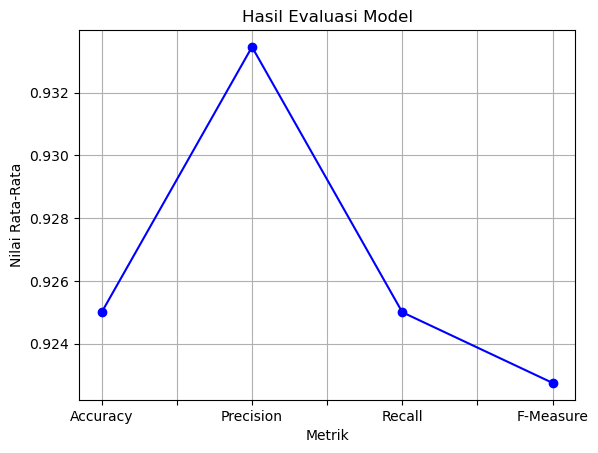

In [47]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

pred = model.predict(X_test)
acc_score = accuracy_score(y_test, pred) 
pre_score = precision_score(y_test, pred, average='weighted')
rec_score = recall_score(y_test, pred, average='weighted')
f_score = f1_score(y_test, pred, average='weighted')

scores = {
    'Accuracy': acc_score,
    'Precision': pre_score,
    'Recall': rec_score, 
    'F-Measure': f_score
}

eval_df = pd.DataFrame.from_dict(scores, orient='index', columns=['Score']) 

eval_df['Score'].plot(kind='line', marker='o', color='blue') 

plt.title('Hasil Evaluasi Model')
plt.xlabel('Metrik') 
plt.ylabel('Nilai Rata-Rata')
plt.grid(True) 

plt.show()

In [48]:
def preprocess_review(review):
    review = review.lower()
    tokens = word_tokenize(review)
    tokens = remove_stopwords(tokens)
    tokens = stem_tokenizer(tokens)
    return ' '.join(tokens)

def predict_sentiment(review):
    preprocessed_review = preprocess_review(review)
    tfidf_review = tfidf_vectorizer.transform([preprocessed_review])
    sentiment = model.predict(tfidf_review)
    return sentiment[0]

In [50]:
new_reviews = [
    "gagal",
    "keren",
    "jelek",
    "Smart locker ini baik",
    "smart locker ini aman",
    "Keamanan smart locker ini sangat tinggi, saya merasa barang-barang saya aman."
]
for review in new_reviews:
    sentiment = predict_sentiment(review)
    print(f"Review: {review}\nPredicted Sentiment: {sentiment}\n")

Review: gagal
Predicted Sentiment: Negative

Review: keren
Predicted Sentiment: Positive

Review: jelek
Predicted Sentiment: Negative

Review: Smart locker ini baik
Predicted Sentiment: Positive

Review: smart locker ini aman
Predicted Sentiment: Positive

Review: Keamanan smart locker ini sangat tinggi, saya merasa barang-barang saya aman.
Predicted Sentiment: Positive

